In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

from sklearn import metrics

import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
## load data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

test = test.drop(test.columns[0], axis=1)
all_data = pd.concat([train, test])

embedding_file = 'data/crawl-300d-2M.vec'

In [25]:
all_data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


Total comments  223533
Total clean comments  201136
Total tags  toxic           21381
severe_toxic     1961
obscene         12137
threat            689
insult          11301
dtype: int64


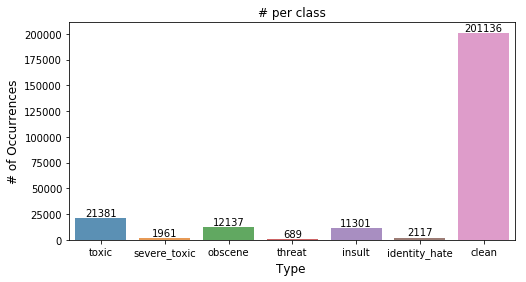

In [3]:
# Data visualizations
# Total clean comments

#marking comments without any tags as "clean"
rowsums = all_data.iloc[:,2:7].sum(axis=1)
all_data['clean'] = np.logical_not(rowsums).astype('int')

x = all_data.iloc[:,2:].sum()

#count number of clean entries
print("Total comments ", len(all_data))
print("Total clean comments ", all_data['clean'].sum())
print("Total tags ", all_data.iloc[:,2:7].sum())

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()


The above visualization clear shows that there is a class imbalance. Even among the toxic types.

In [27]:
# check for nulls
train.isnull().any(),test.isnull().any()

(id               False
 comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 dtype: bool, id               False
 comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 dtype: bool)

In [4]:
# split data by class
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
y_test = test[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]


In [5]:
# clean data
special_character_removal=re.compile(r'[^a-z\d ]',re.IGNORECASE)
replace_numbers=re.compile(r'\d+',re.IGNORECASE)

def text_to_words(text):
    text=special_character_removal.sub('',text)
    
    #Replace Numbers
    text=replace_numbers.sub('n',text)

    # Clean the text, with the option to remove stopwords and to stem words.
    # Convert words to lower case and split them
    text = text.lower().split()
    
    # remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)

    # shorten words to their stems
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
        
    return text

comments = []
for text in list_sentences_train:
    comments.append(text_to_words(text))
    
test_comments=[]
for text in list_sentences_test:
    test_comments.append(text_to_words(text))

In [6]:
# tokenize strings
max_features = 20000
maxlen = 100
tokenizer = Tokenizer(num_words=max_features,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'', lower=True)
tokenizer.fit_on_texts(list(comments + test_comments))
comments_sequence = tokenizer.texts_to_sequences(comments)
test_comments_sequence = tokenizer.texts_to_sequences(test_comments)    
X_t = pad_sequences(comments_sequence , maxlen=maxlen)
X_te = pad_sequences(test_comments_sequence, maxlen=maxlen)


In [15]:
# embedding
# glove

embed_size =300

def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(embedding_file, encoding="utf8"))

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector


In [7]:
# visualize word distribution
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

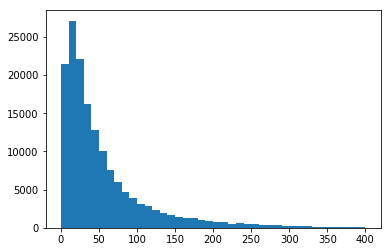

In [8]:
plt.hist(totalNumWords,bins = np.arange(0,410,10))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()

In [34]:
# Define keras input layer
inp = Input(shape=(maxlen, )) #maxlen=200 as defined earlier

# define embedding layer
embed_size = 300
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)

# define lstm layer
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)

# pooling & dropout
x = GlobalMaxPool1D()(x)
x = Dropout(0.2)(x)

# output layer
x = Dense(50, activation="relu")(x)
x = Dropout(0.2)(x)

# sigmoid for classification
x = Dense(6, activation="sigmoid")(x)

# create model
model = Model(inputs=inp, outputs=x)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 100, 300)          6000000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 100, 60)           86640     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 60)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
__________

In [35]:
# compile model
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [65]:
from keras.models import load_model
model = load_model('model.h5')

In [36]:
# train model
batch_size = 32
epochs = 2
model.fit(X_t, y, batch_size=batch_size, epochs=epochs, validation_split=0.1)
model.save('model.h5')

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 424s 3ms/step - loss: 0.0637 - acc: 0.9787 - val_loss: 0.0507 - val_acc: 0.9814
Epoch 2/2
143613/143613 [==============================] - 391s 3ms/step - loss: 0.0464 - acc: 0.9827 - val_loss: 0.0506 - val_acc: 0.9819


In [37]:
batch_size = 32
epochs = 2
predictions = model.predict(X_te, batch_size=batch_size, verbose=1)

63962/63962 [==============================] - 31s 484us/step


In [38]:
print("roc auc score ", metrics.roc_auc_score(y_test, predictions))
print("accuracy ", metrics.accuracy_score(y_test, np.round(predictions).astype(np.int)))
print("precision score ", metrics.precision_score(y_test, np.round(predictions).astype(np.int),  average='weighted'))
print("recall score ", metrics.recall_score(y_test, np.round(predictions).astype(np.int),  average='weighted'))
print("f1 score ", metrics.f1_score(y_test, np.round(predictions).astype(np.int), average='weighted'))

print("coverage error ", metrics.coverage_error(y_test, predictions))
print("label ranking average precision score ", metrics.label_ranking_average_precision_score(y_test, predictions))
print("label ranking loss ", metrics.label_ranking_loss(y_test, predictions))

roc auc score  0.9734599385842279
accuracy  0.8870892092179732
precision score  0.6235328034057503
recall score  0.6813914964108228
f1 score  0.6418088146254664
coverage error  0.2416747443794753


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


label ranking average precision score  0.9975677094733322
label ranking loss  0.0023176087190658343


Fast text very slightly improved upon glove